# 08. 사후추론과 예측

In [2]:
library(bayesrules)
library(tidyverse)
library(rstan)
library(bayesplot)
library(broom.mixed)
library(janitor)

In [4]:
data("moma_sample")

In [5]:
moma_sample %>% 
  group_by(genx) %>% 
  tally()

genx,n
<lgl>,<int>
FALSE,86
TRUE,14


<br>

#### 예술가가 X세대일 확률 $\pi$에 대하여
- 관측값의 분포 & 매개변수의 사전분포
$$\begin{split}
Y | \pi & \sim \text{Bin}(100, \pi) \\
\pi & \sim \text{Beta}(4, 6) \\
\end{split} \;\;\;\; \Rightarrow \;\;\;\; \pi | (Y = 14) \sim \text{Beta}(18, 92)$$

- 이론적 사후분포
$$\begin{equation}
f(\pi | y = 14) = \frac{\Gamma(18 + 92)}{\Gamma(18)\Gamma(92)}\pi^{18-1} (1-\pi)^{92-1} \;\; \text{ for } \pi \in [0,1]  .
\end{equation}$$

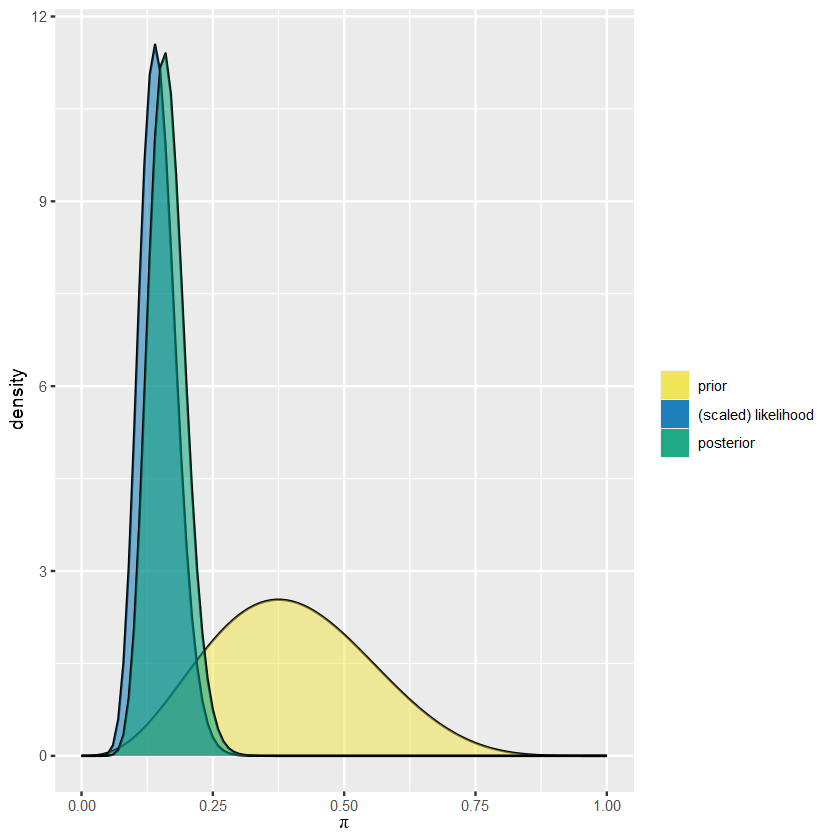

In [6]:
plot_beta_binomial(alpha = 4, beta = 6, y = 14, n = 100)

<br>

## 08.01. 사후분포 신용구간

> 매개변수 $\pi$가 사후분포 확률밀도함수를 $f(\pi | y)$로 가질 때,
>
> 사후분포의 신용구간(Credible Interval)은 $\pi$값 추정치의 타당한 범위를 제공하며,
>
> 중심성과 산포도를 반영한다

> 95% 신용구간은, 사후분포의 2.5분위수와 97.5분위수 값을 통하여 계산되며
> $$(\pi_{0.025}, \pi_{0.975})  .$$
>
> $\pi$에 대한 사후분포의 95% 신용구간에 대해서
> $$P(\pi \in (\pi_{0.025}, \pi_{0.975}) | Y=y) = \int_{\pi_{0.025}}^{\pi_{0.975}} f(\pi|y)d\pi = 0.95  .$$이 성립


<br>

## 08.02. 사후가설검정
$$\begin{split}
H_0: & \; \; \pi \ge 0.2 \\
H_a: & \; \; \pi < 0.2 \\
\end{split}$$

### (1) 단측검정

#### 사후확률 
#### 사후분포에서 (관측이후),  대립가설이 성립할 확률

$$P(\pi < 0.2 \; | \; Y = 14) = \int_{0}^{0.2}f(\pi | y=14)d\pi .$$

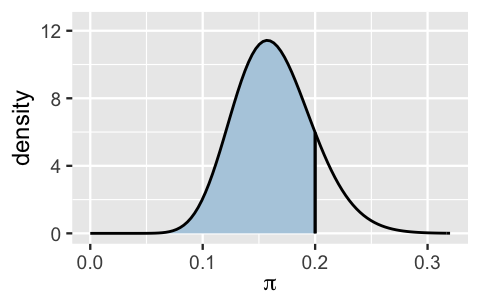

In [10]:
post_prob <- pbeta(0.20, 18, 92)
post_prob

[1] 0.8489856

$$P(H_0 \; | \; Y=14) = 0.151$$

In [11]:
1-post_prob

[1] 0.1510144

<br>

#### 사후오즈
#### 사후분포 (관측이후)에서, 대립가설이 성립할 확률과 그렇지 않을 확률의 비율

<br>

$$\text{posterior odds } = \frac{P(H_a \; | \; Y=14)}{P(H_0 \; | \; Y=14)} \approx 5.62.$$

In [17]:
post_odds <- post_prob / (1 - post_prob)
post_odds

[1] 5.621883

<br>

### 사전확률
#### 사전분포에서 (관측이전), 대립가설이 성립할 확률

$$P(H_a) = \int_0^{0.2} f(\pi) d\pi \approx 0.0856  .$$

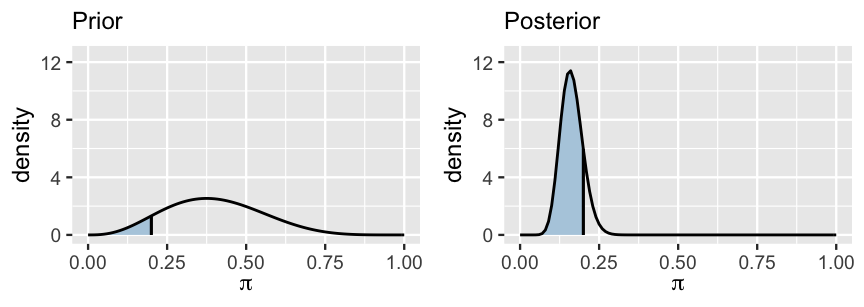

In [14]:
prior_prob <- pbeta(0.20, 4, 6)
prior_prob

[1] 0.08564173

$$P(H_0) = 0.914$$

In [15]:
1-prior_prob

[1] 0.9143583

<br>

#### 사전오즈
#### 사전분포 (관측이전)에서, 대립가설이 성립할 확률과 그렇지 않을 확률의 비율
$$\text{Prior odds } = \frac{P(H_a)}{P(H_0)} \approx 0.093  .$$

In [18]:
prior_odds <- prior_prob / (1 - prior_prob)
prior_odds

[1] 0.09366321

<br>

### 베이즈 요인 (Bayes Factor)
> **사후오즈와 사전오즈간의 비율**
>
> $$\text{Bayes Factor}
= \frac{\text{posterior odds}}{\text{prior odds}}
= \frac{P(H_a | Y) / P(H_0 | Y)}{P(H_a) / P(H_0)}
  .$$
  
> 1. **베이즈 요인 $= 1$ : 관측에 의한 갱신에도 불구하고 대립가설의 타당성이 변하지 않음**
> 2. **베이즈 요인 $> 1$ : 관측에 의한 갱신을 통하여, 대립가설 타당성이 높아짐을 확인**
> 3. **베이즈 요인 $< 1$ : 관측에 의한 갱신을 통하여, 대립가설 타당성이 감소함을 확인**

In [19]:
BF <- post_odds / prior_odds
BF

[1] 60.02232


#### 베이즈 요인과 사후오즈 모두가 1보다 크다는 것은, 귀무가설 기각을 위한 중요한 근거

<br>

### (2) 양측검정

$$\begin{split}
H_0: & \; \; \pi = 0.3 \\
H_a: & \; \; \pi \ne 0.3 \\
\end{split}$$

#### 95% 신용구간에 포함되는지 여부를 통하여 검정

$$\begin{split}
H_0: & \; \; \pi \in (0.25, 0.35) \\
H_a: & \; \; \pi \notin (0.25, 0.35) \\
\end{split}$$

<br>

## 08.03. 사후예측
> $Y'$가 $Y$의 신규 관측값이고,
>
>   $f(y'|\pi)$이 $Y'$의 $\pi$에 대한 의존성을 나타내고
>    
>    $f(\pi|y)$가 $Y=y$관측에 따른 $\pi$의 사후분포 확률밀도함수일 때, 
>    
>    $Y'$에 대한 사후예측분포의 Pdf는
>    $$\begin{equation}
f(y'|y) = \int f(y'|\pi) f(\pi|y) d\pi
\end{equation}$$로서
>
>  **사후분포에 의한 $\pi$값의 모든 범위에서 $Y=y'$를 관측할 확률**

> 따라서, 
>
> **1. 신규 관측값 $Y'$의 변동성에 대한 정의와**
>
> **2. 기존 관측값에 의하여 도출된 사후분포와, 사후분포에 의한 $\pi$값의 범위와 변동성에 대한 정의가 필요**

<br>

## 08.05. MCMC를 통한 사후분포 분석

<br>

### MCMC 시뮬레이션

In [20]:
art_model <- "
  data {
    int<lower = 0, upper = 100> Y;
  }
  parameters {
    real<lower = 0, upper = 1> pi;
  }
  model {
    Y ~ binomial(100, pi);
    pi ~ beta(4, 6);
  }
"

In [ ]:
art_sim <- stan(model_code = art_model, data = list(Y = 14), 
                chains = 4, iter = 5000*2, seed = 84735)

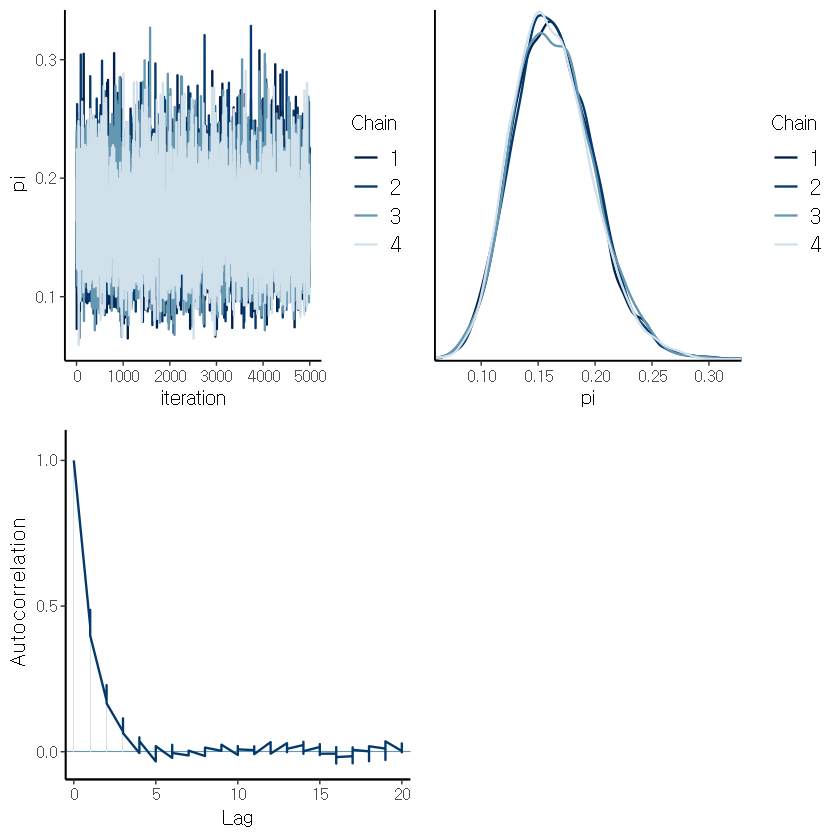

In [25]:
mcmc_trace(art_sim, pars = "pi", size = 0.5) + 
  xlab("iteration") -> p1
mcmc_dens_overlay(art_sim, pars = "pi") -> p2
mcmc_acf(art_sim, pars = "pi") -> p3

gridExtra::grid.arrange(p1, p2, p3, nrow = 2)

In [26]:
rhat(art_sim, pars = "pi")

[1] 1.001055

In [27]:
neff_ratio(art_sim, pars = "pi")

[1] 0.4031542

<br>

### 사후분포 추정 & 가설검정

#### 이론적 사후분포 $Beta(18, 92)$와 MCMC 사후분포 근사의 비교

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


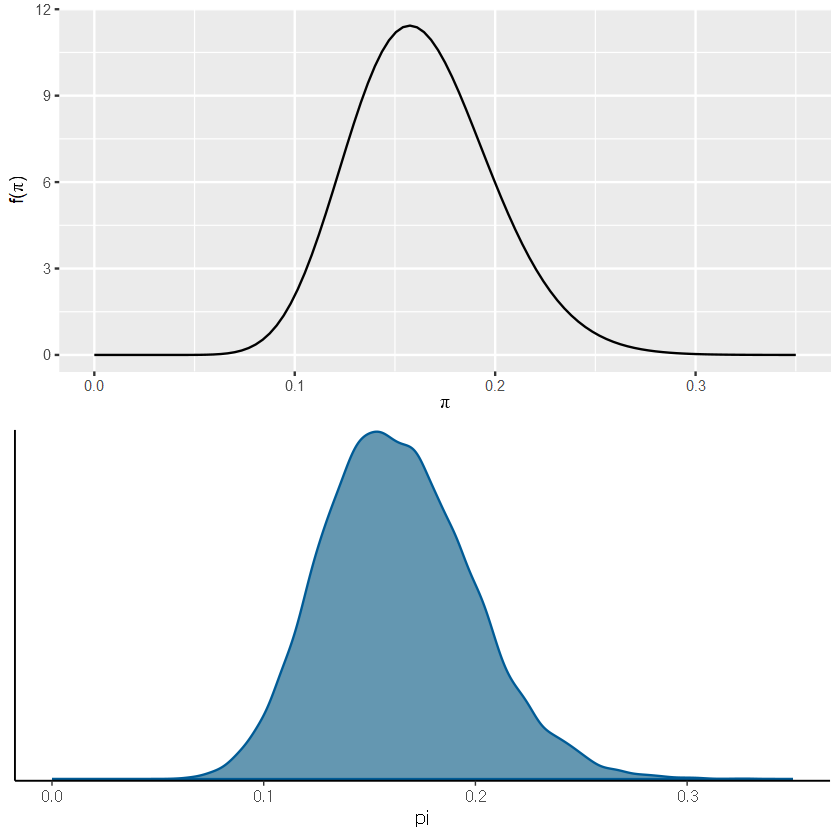

In [31]:
plot_beta(alpha = 18, beta = 92) + 
  lims(x = c(0, 0.35)) -> p1
mcmc_dens(art_sim, pars = "pi") + 
  lims(x = c(0,0.35)) -> p2

gridExtra::grid.arrange(p1, p2)

<br>

#### MCMC값의 신용구간 확인

In [32]:
tidy(art_sim, conf.int = TRUE, conf.level = 0.95)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
pi,0.1614584,0.03510454,0.100797,0.2387512


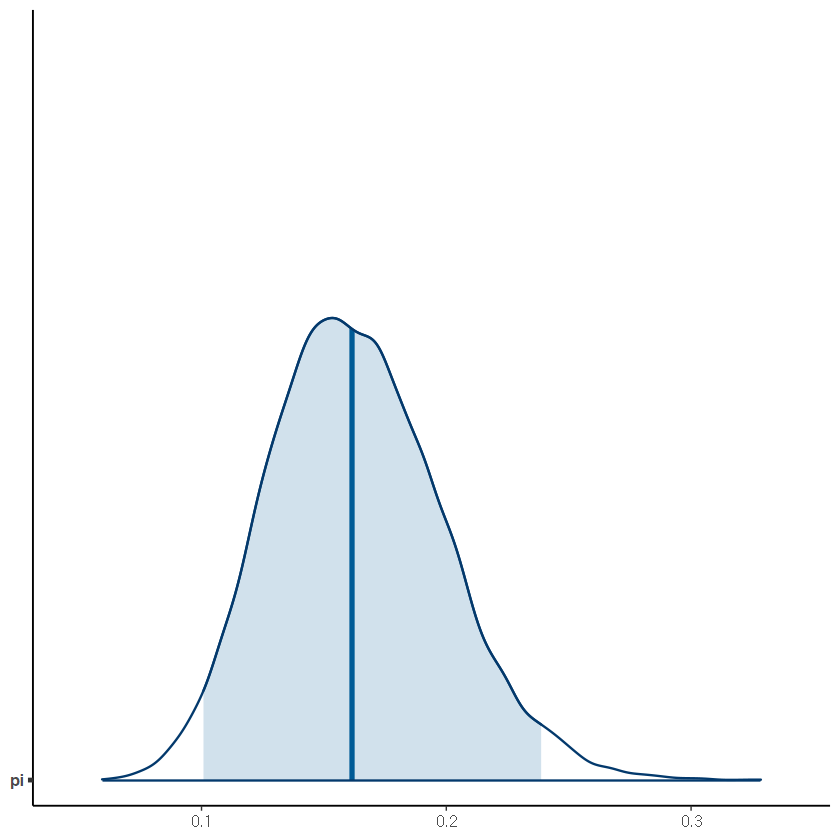

In [33]:
mcmc_areas(art_sim, pars = "pi", prob = 0.95)

In [38]:
art_chains_df <- as.data.frame(art_sim, pars = "lp__", include = FALSE)

In [39]:
art_chains_df %>% 
  summarize(post_mean = mean(pi), 
            post_median = median(pi),
            post_mode = sample_mode(pi),
            lower_95 = quantile(pi, 0.025),
            upper_95 = quantile(pi, 0.975))

post_mean,post_median,post_mode,lower_95,upper_95
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1635274,0.1614584,0.1532068,0.100797,0.2387512


<br>

#### 가설검정
$$\begin{split}
H_0: & \; \; \pi \ge 0.2 \\
H_a: & \; \; \pi < 0.2 \\
\end{split}$$

In [40]:
art_chains_df %>% 
  mutate(exceeds = pi < 0.20) %>% 
  tabyl(exceeds)

exceeds,n,percent
<lgl>,<int>,<dbl>
FALSE,3011,0.15055
TRUE,16989,0.84945


<br>

#### 사후예측분포
1. **신규 관측값 $Y'$에 대한 변동성**

- $Y'$가 $N=20$인 이항분포 따른다고 가정 

$$Y'| \pi \sim \text{Bin}(20,\pi)$$

* MCMC에 의한 사후분포 근사치는, $\pi$값의 범위와 변동성에 대한 정보제공

In [41]:
set.seed(1)

In [42]:
art_chains_df <- art_chains_df %>% 
  mutate(y_predict = rbinom(length(pi), size = 20, prob = pi))

<br>


In [43]:
art_chains_df %>% 
  head(3)

,pi,y_predict
,<dbl>,<int>
1,0.1300704,2
2,0.1755165,3
3,0.2214147,5


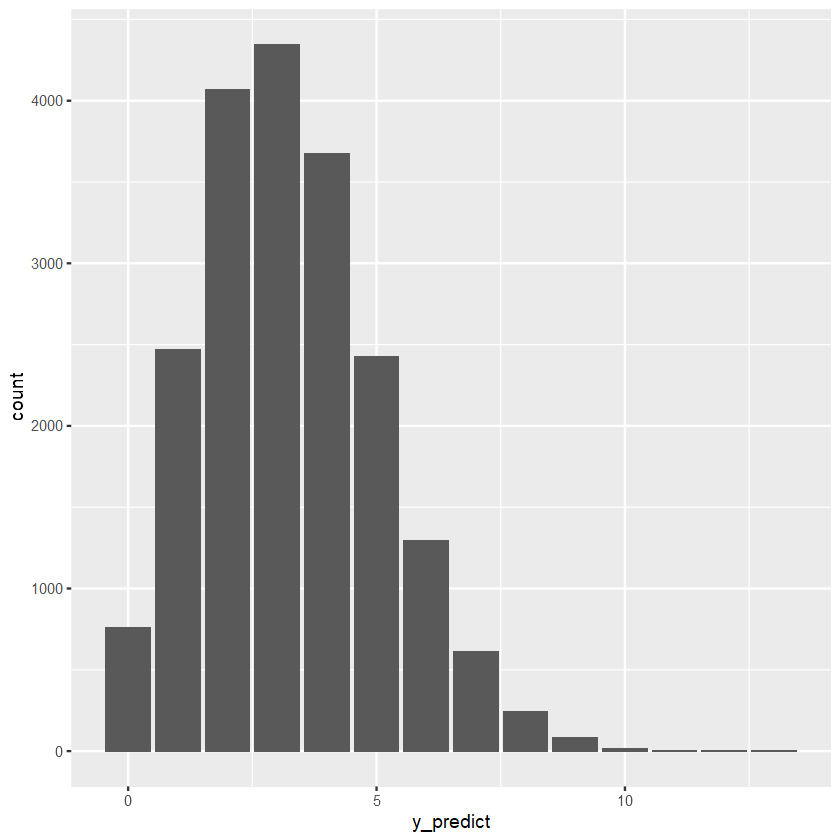

In [44]:
ggplot(art_chains_df, aes(x = y_predict)) + 
  stat_count()

In [45]:
art_chains_df %>% 
  summarize(mean = mean(y_predict),
            lower_80 = quantile(y_predict, 0.1),
            upper_80 = quantile(y_predict, 0.9))

mean,lower_80,upper_80
<dbl>,<dbl>,<dbl>
3.27185,1,6
